In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sympy as sp

El objetivo va a ser lograr obtener la evolución temporal y el diagrama de fases para el mismo hamiltoniano que hemos estudiado cuánticamente y ver sus semejanzas y diferencias. El hamiltoniano es:
\begin{equation}
H_{0} = -\frac{4 J}{N} (S_{z})^{2}-2hS_{x}-\frac{16K}{N^{3}} (S_{z})^{4}
\end{equation}
Para poder aplicar las ecuaciones de Hamilton, necesitamos que esté en función de las coordenadas generalizadas $q_{i}$ y momentos generalizados $p_{i}$. En este caso, según se ha calculado en el artículo de las referencia [8], hay que hacer la sustitución:

\begin{gather}
    S_{z} = \frac{q^{2}+p^{2}}{2} - 1\\
    S_{x} = q \frac{\sqrt{4-q^{2}-p^{2}}}{2}
\end{gather}

Para hacer más visual las curvas de nivel en el espacio de fases rotamos nuestro SDRF 90 grados de manera que $S_{z} \longrightarrow - S_{x}$ y $S_{x} \longrightarrow S_{z}$. Ahora construimos el hamiltoniano en nuestro código y calculamos las derivadas parciales del hamiltoniano que nos permitirán obtener los puntos fijos y posteriormente la evolución temporal:

In [2]:
def S_x(p,q):
    return -((q**2+p**2)/2 - 1)
def S_z(p,q):
    return q*np.sqrt(4-q**2-p**2)/2

def H(N,J,h,K,p,q):
    return -(4*J/N) *(S_z(p,q))**2-2*h*S_x(p,q)-(16*K)/(N**3) * (S_z(p,q))**4

# Definir variables
N, J, h, K, p, q = sp.symbols('N J h K p q')

# Definir s_x y s_z
sx=-((p**2+q**2)/2 - 1)
sz=q*sp.sqrt(4-q**2-p**2)/2

# Definir H(x, y) en términos de g y h
H = -(4*J/N) *(sz)**2-2*h*sx-(16*K)/(N**3) * (sz)**4

# Expandir la expresión para ver cómo queda en términos de x e y
H_expanded = H.expand()

print("H sin expandir en términos de p y q:", H)
print("H en términos de p y q:", H_expanded)

dH_dq = sp.diff(H, q)  # Derivada parcial respecto a x
dH_dp = sp.diff(H, p)  # Derivada parcial respecto a y
print("dH/dq=",sp.simplify(dH_dq))
print("dH/dp=",sp.simplify(dH_dp))



H sin expandir en términos de p y q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)
H en términos de p y q: J*p**2*q**2/N + J*q**4/N - 4*J*q**2/N - K*p**4*q**4/N**3 - 2*K*p**2*q**6/N**3 + 8*K*p**2*q**4/N**3 - K*q**8/N**3 + 8*K*q**6/N**3 - 16*K*q**4/N**3 + h*p**2 + h*q**2 - 2*h
dH/dq= 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3
dH/dp= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3


Para encontrar los mínimos del hamiltoniano, puntos donde se situaría el sistema en el estado fundamental, buscamos el lugar geométrico donde se cumpla el sistema de ecuaciones:

\begin{gather}
    \frac{\partial H}{\partial p}=0\\
    \frac{\partial H}{\partial q}=0
\end{gather}
Esto lo hacemos con el hamiltoniano inicial, cuyo estado fundamental es del que vamos a partir en la evolucón temporal tras el quench.

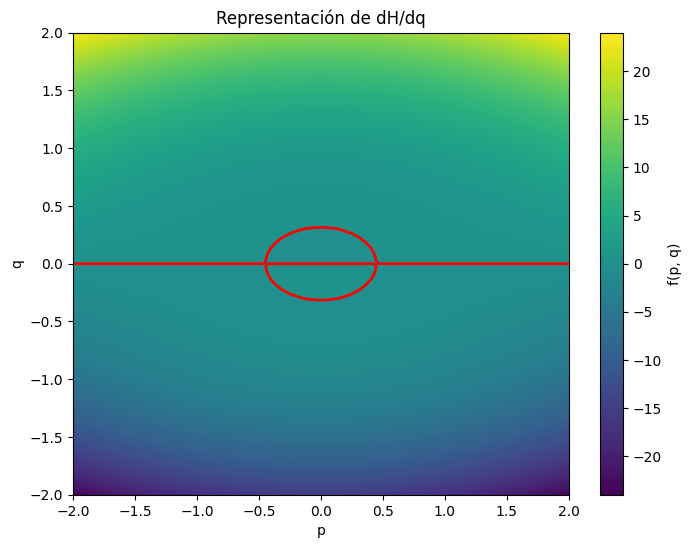

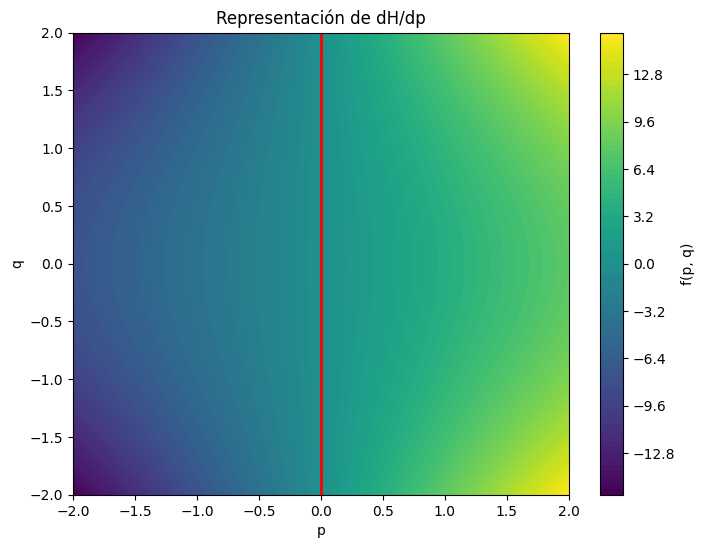

(-0.3162284851074219, 19, 7.629394531138978e-07)
(0.3162284851074219, 19, 7.629394531138978e-07)
(-7.62939453125e-07, 18, 7.62939453125e-07)


In [3]:
from scipy.optimize import root_scalar

def plot_f_pq(f,name, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(P, Q, F, levels=100, cmap='viridis')
    plt.colorbar(label='f(p, q)')
    plt.xlabel('p')
    plt.ylabel('q')
    plt.title(f'Representación de {name}')
    plt.contour(P, Q, F, levels=[0], colors='red', linewidths=2)
    plt.show()

h = 1.9
K = 0
N = 1500
J = N/2


plot_f_pq(lambda p, q: 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3,"dH/dq")
plot_f_pq(lambda p ,q: 2*p*(J*N**2*q**2- 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3,"dH/dp")

def f(q):
    p=0
    return 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + N**3*h)/N**3

def biseccion(f,x1,x2,eps,N_max):
    if np.sign(f(x1))!=np.sign(f(x2)):
        N=0
        while abs(x1-x2)>eps and N<N_max:
            N+=1
            xp=0.5*(x1+x2)
            if np.sign(f(xp))==np.sign(f(x1)):
                x1=xp
            else:
                x2=xp
        return xp,N,abs(x1-x2)
    else:
        print("No existe raiz o el intervalo es otro")
        return

print(biseccion(f,-0.5,-0.1,10**-6,1000))
print(biseccion(f,0.1,0.5,10**-6,1000))
print(biseccion(f,-0.1,0.1,10**-6,1000))

Para sacar los puntos fijos aprovechamos que todos los puntos donde se anula $\frac{\partial H}{\partial p}$ es en la recta p=0, minimizando en una dimension H(p=0,q) y siendo los valores donde corta esta recta con los puntos donde se anula $\frac{\partial H}{\partial q}$. Para hacer más visuales y ver si estos puntos fijos son puntos de silla, máximos o mínimos representamos nuestro hamiltoniano H(p,q).

Mínimo encontrado en (p, q): [0. 0.]
Valor mínimo de H: -3.8


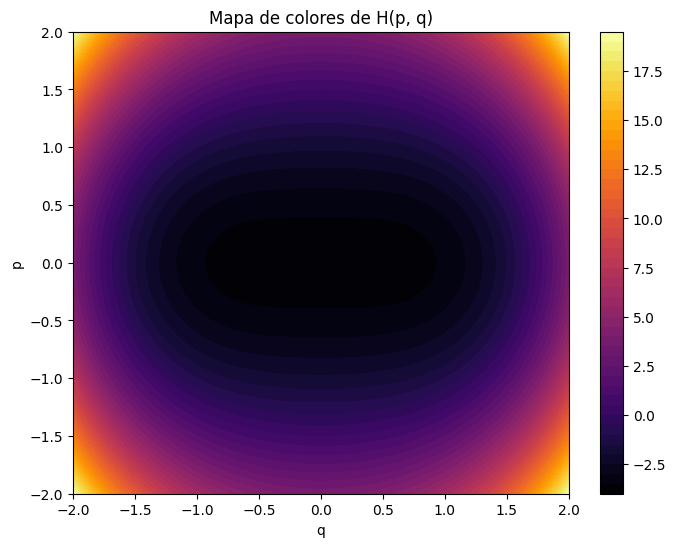

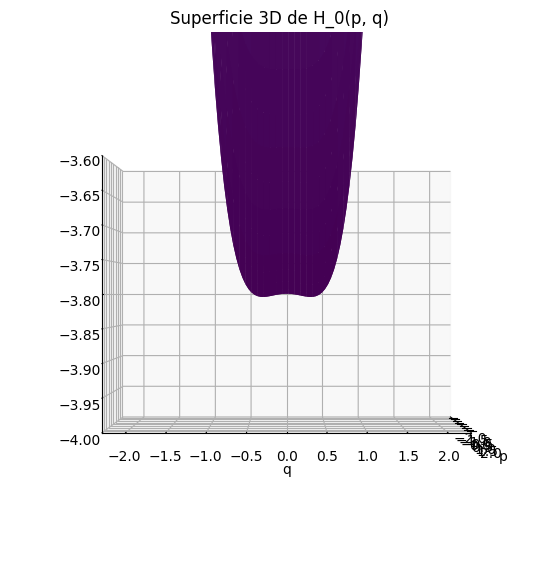

In [4]:
import numpy as np
from scipy.optimize import minimize

# Definir constantes
N = 1500
J = N/2
h = 1.9
K = 0*3*(N/2)**3


# Definir la función H(p, q)
def H(x):
    p, q = x  # Desempaquetamos p y q
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

# Condiciones iniciales (p, q)
x0 = [0, 0]  # Puedes probar con otros valores iniciales

# Minimización de H(p, q)
resultado = minimize(H, x0, method='BFGS')

# Mostrar resultados
print("Mínimo encontrado en (p, q):", resultado.x)
print("Valor mínimo de H:", resultado.fun)

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

def H(p,q):
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title("Mapa de colores de H(p, q)")
plt.show()

def plot_f_pq_3d(f, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, Q, F, cmap='viridis', edgecolor='none')
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    #ax.set_zlabel('f(p, q)')
    ax.set_title('Superficie 3D de H_0(p, q)')
    ax.set_zlim(-4,-3.6)
    ax.view_init(elev=0, azim=0)
    
    plt.show()
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))


Los puntos fijos efectivamente coinciden con los dos minimos y un punto de silla  para el hamiltoniano inicial. Los dos mínimos se sitúan en los puntos (-0.3162284851074219,0) y (0,-0.3162284851074219) con energía E=-3.805, mientras que el punto de silla en (0,0), con energía E=-3.8. Esto daría lugar a un estado inicial ferromagnético (magnetización no nula).

A continuación, procedemos a evolucionar el sistema con el hamiltoniano final hf=5 y Kf=3. Para ello utilizaremos el método Runge-Kutta de cuarto orden con paso fijo para resolver las ecuaciones de Hamilton. Es necesario escoger un paso lo suficientemente pequeño para que recoja la evolución real del sistema dada la alta velocidad de variación de q y p.

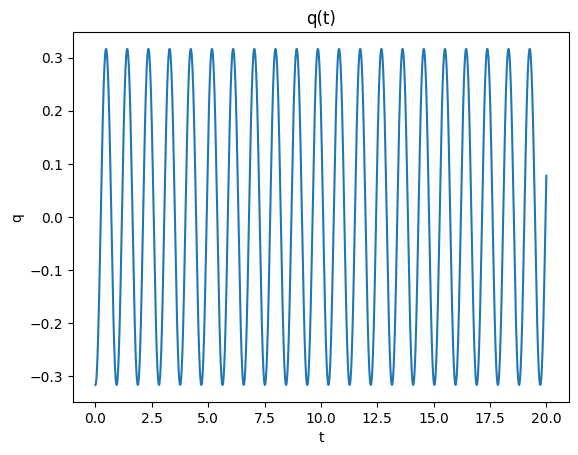

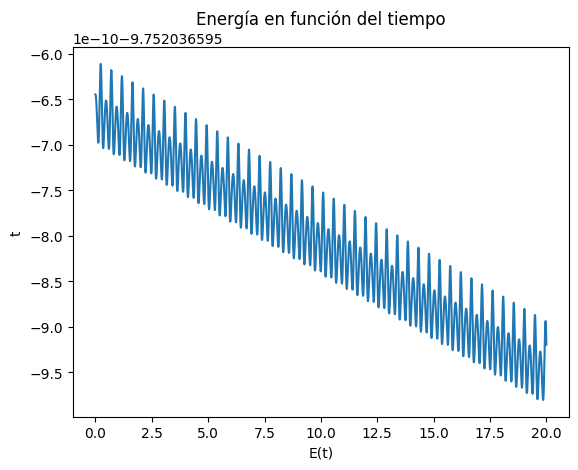

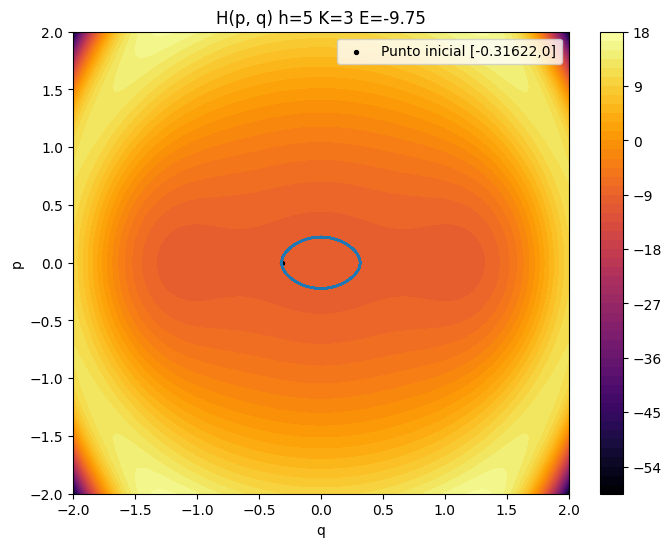

In [9]:
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def f(r,t):
    #Ahora usamos las variables finales para la evolucion temporal
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p=r[0]
    q=r[1]
    fp= -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp,fq],float)


a=0 # punto inicial del intervalo
b=20 # punto final del intervalo
Np=10000 # número de puntos

hp=(b-a)/Np # tamaño del paso


tp=np.linspace(a,b,Np) # inicializamos nuestras soluciones para un array de puntos en t
pp=[]
qp=[]
r=np.array([0,-0.3162284851074219],float) # condiciones iniciales para nuestras soluciones

for t in tp:
    pp.append(r[0])
    qp.append(r[1])
    k1 = hp*f(r,t)
    k2 = hp*f(r+0.5*k1,t+0.5*hp)
    k3 = hp*f(r+0.5*k2,t+0.5*hp)
    k4 = hp*f(r+k3,t+hp)
    r += (k1+2*k2+2*k3+k4)/6
    

plt.plot(tp,qp)
plt.title("q(t)")
plt.xlabel("t")
plt.ylabel("q")
plt.xlabel("t")
plt.show()

def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)
plt.plot(tp,H(np.array(pp),np.array(qp)))
plt.xlabel('E(t)')
plt.ylabel('t')
plt.title("Energía en función del tiempo")
plt.show()

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title("H(p, q) h=5 K=3 E=-9.75")
plt.plot(np.array(qp),np.array(pp))
plt.scatter(-0.3162284851074219,0,color="black",s=8,label="Punto inicial [-0.31622,0]")
plt.legend()
plt.show()


Vamos ahora a probar a ver que ocurre con otro hamiltoniano inicial h=2.4, K=0.8:

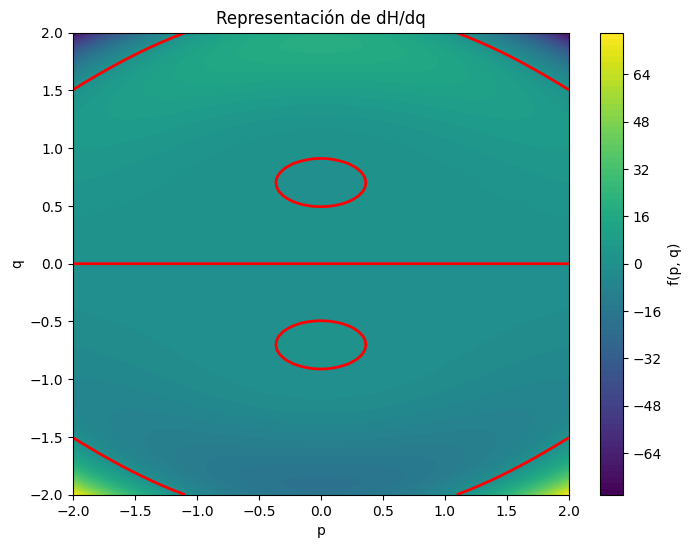

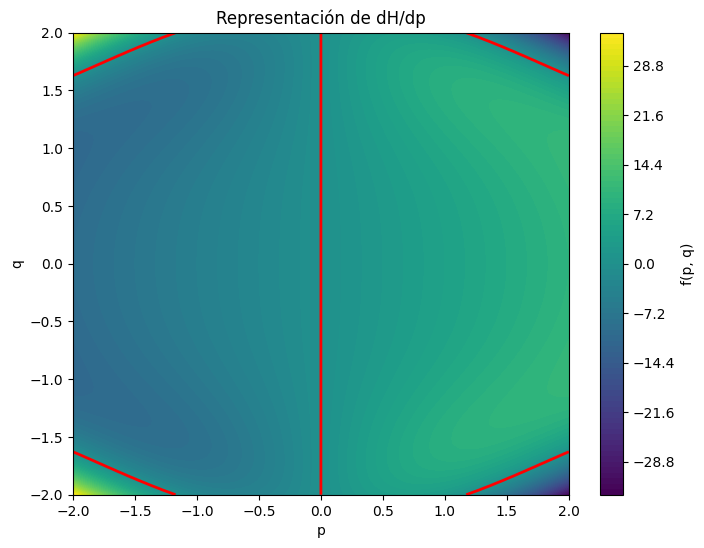

(0.9118177413940428, 20, 5.722045898215455e-07)
(0.49421768188476567, 19, 7.629394531138978e-07)
(-7.62939453125e-07, 18, 7.62939453125e-07)


In [6]:
#Voy a plotear dH/dp y dH/dq:
from scipy.optimize import root_scalar

def plot_f_pq(f,name, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(P, Q, F, levels=100, cmap='viridis')
    plt.colorbar(label='f(p, q)')
    plt.xlabel('p')
    plt.ylabel('q')
    plt.title(f'Representación de {name}')
    plt.contour(P, Q, F, levels=[0], colors='red', linewidths=2)
    plt.show()

h = 2.4
K = 0.8*(N/2)**3
N = 1500
J = N/2


plot_f_pq(lambda p, q: 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3,"dH/dq")
plot_f_pq(lambda p ,q: 2*p*(J*N**2*q**2- 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3,"dH/dp")

def f(q):
    p=0
    return 2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3

def biseccion(f,x1,x2,eps,N_max):
    if np.sign(f(x1))!=np.sign(f(x2)):
        N=0
        while abs(x1-x2)>eps and N<N_max:
            N+=1
            xp=0.5*(x1+x2)
            if np.sign(f(xp))==np.sign(f(x1)):
                x1=xp
            else:
                x2=xp
        return xp,N,abs(x1-x2)
    else:
        print("No existe raiz o el intervalo es otro")
        return

print(biseccion(f,0.6,1.2,10**-6,1000))
print(biseccion(f,0.1,0.5,10**-6,1000))
print(biseccion(f,-0.1,0.1,10**-6,1000))

Mínimo encontrado en (p, q): [-1.29306150e-09  9.11817818e-01]
Valor mínimo de H: -4.81581967833489


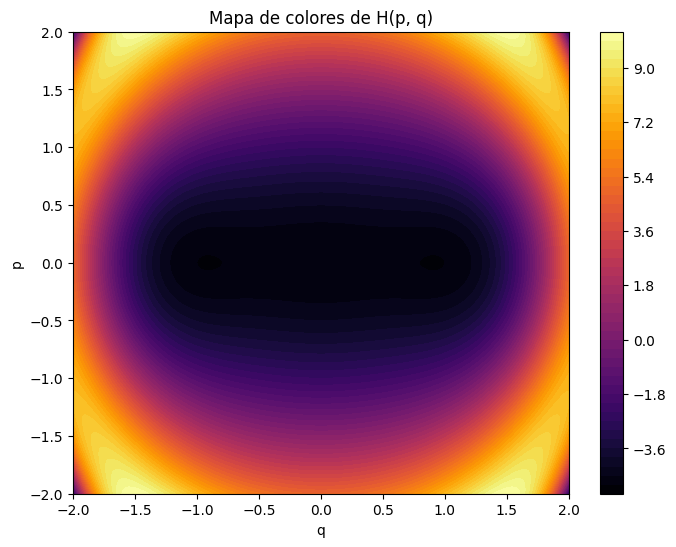

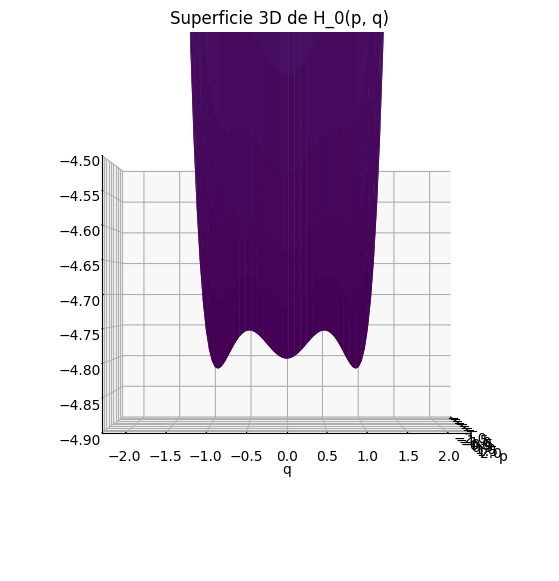

In [7]:
import numpy as np
from scipy.optimize import minimize

# Definir constantes
N = 1500
J = N/2
h = 2.4
K = 0.8*(N/2)**3


# Definir la función H(p, q)
def H(x):
    p, q = x  # Desempaquetamos p y q
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

# Condiciones iniciales (p, q)
x0 = [0, 0.5]  # Puedes probar con otros valores iniciales

# Minimización de H(p, q)
resultado = minimize(H, x0, method='BFGS')

# Mostrar resultados
print("Mínimo encontrado en (p, q):", resultado.x)
print("Valor mínimo de H:", resultado.fun)

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

def H(p,q):
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title("Mapa de colores de H(p, q)")
plt.show()

def plot_f_pq_3d(f, p_range=(-2, 2), q_range=(-2, 2), grid_size=100):
    p = np.linspace(p_range[0], p_range[1], grid_size)
    q = np.linspace(q_range[0], q_range[1], grid_size)
    P, Q = np.meshgrid(p, q)
    F = f(P, Q)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(P, Q, F, cmap='viridis', edgecolor='none')
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    #ax.set_zlabel('f(p, q)')
    ax.set_title('Superficie 3D de H_0(p, q)')
    ax.set_zlim(-4.9,-4.5)
    ax.view_init(elev=0, azim=0)
    plt.show()
plot_f_pq_3d(lambda p, q: -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1))

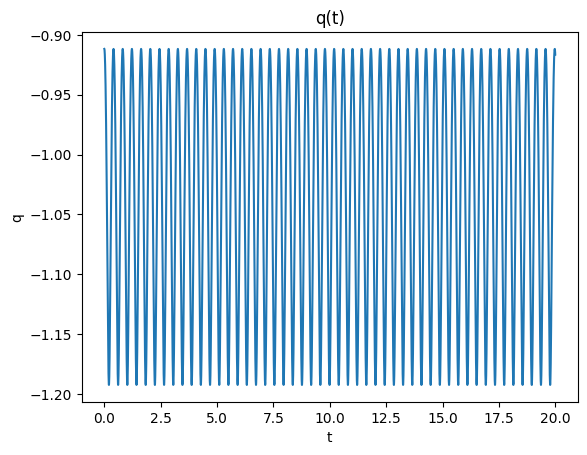

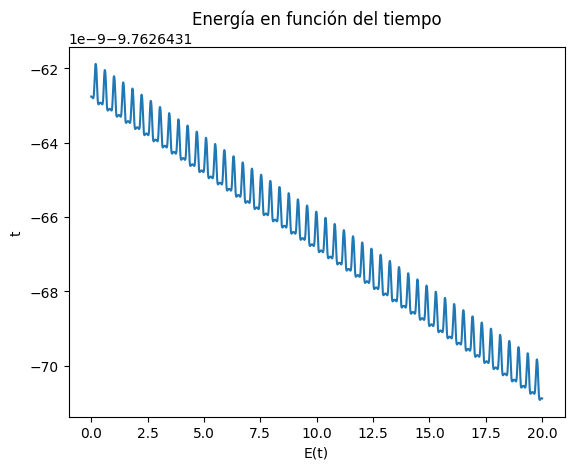

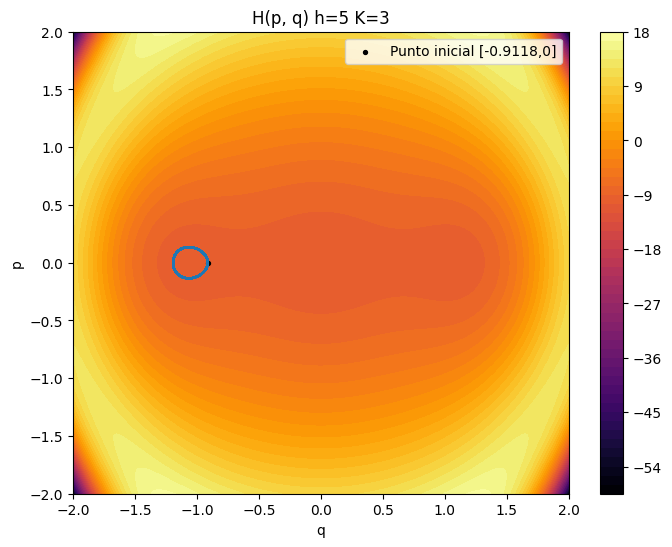

In [12]:
def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

def f(r,t):
    #Ahora usamos las variables finales para la evolucion temporal
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    p=r[0]
    q=r[1]
    fp= -(2*q*(J*N**2*(p**2 + 2*q**2 - 4) + 2*K*q**2*(-p**2 - 2*q**2 + 4)*(p**2 + q**2 - 4) + N**3*h)/N**3)
    fq= 2*p*(J*N**2*q**2 - 2*K*q**4*(p**2 + q**2 - 4) + N**3*h)/N**3
    return np.array([fp,fq],float)


a=0 # punto inicial del intervalo
b=20 # punto final del intervalo
Np=15000 # número de puntos

hp=(b-a)/Np # tamaño del paso


tp=np.linspace(a,b,Np) # inicializamos nuestras soluciones para un array de puntos en t
pp=[]
qp=[]
r=np.array([0,-0.9118],float) # condiciones iniciales para nuestras soluciones



for t in tp:
    pp.append(r[0])
    qp.append(r[1])
    k1 = hp*f(r,t)
    k2 = hp*f(r+0.5*k1,t+0.5*hp)
    k3 = hp*f(r+0.5*k2,t+0.5*hp)
    k4 = hp*f(r+k3,t+hp)
    r += (k1+2*k2+2*k3+k4)/6
    

plt.plot(tp,qp)
plt.title("q(t)")
plt.xlabel("t")
plt.ylabel("q")
plt.xlabel("t")
plt.show()

def H(p,q):
    N = 1500
    J = N/2
    h = 5
    K = 3*(N/2)**3
    return -J*q**2*(-p**2 - q**2 + 4)/N - K*q**4*(-p**2 - q**2 + 4)**2/N**3 - 2*h*(-p**2/2 - q**2/2 + 1)

H=np.vectorize(H)
plt.plot(tp,H(np.array(pp),np.array(qp)))
plt.xlabel('E(t)')
plt.ylabel('t')
plt.title("Energía en función del tiempo")
plt.show()

# Definir el rango de valores para P y Q
p_values = np.linspace(-2, 2, 500)  # Valores de P (eje y)
q_values = np.linspace(-2, 2, 500)  # Valores de Q (eje x)

# Crear la malla de valores de P y Q
P, Q = np.meshgrid(p_values, q_values)

# Evaluar H en cada punto de la malla
H_values = H(P, Q)

# Crear la figura 
plt.figure(figsize=(8, 6))
plt.contourf(Q, P, H_values, levels=50, cmap='inferno')  # Heatmap de colores
plt.colorbar()  # Barra de colores
plt.xlabel("q")
plt.ylabel("p")
plt.title("H(p, q) h=5 K=3")
plt.plot(np.array(qp),np.array(pp))
plt.scatter(-0.9118,0,color="black",s=8,label="Punto inicial [-0.9118,0]")
plt.legend()
plt.show()